## BigQuery NYC Taxi Data EDA (Region)
### Goals
- EDA of NYC taxi data with focus on region and demand
    - Reverse geocoding (longitude/latitude to address) based on Shp file (`bigquery-public-data.geo_us_boundaries.zip_codes`)
    - [BigQuery GIS](https://cloud.google.com/bigquery/docs/gis-intro?hl=ko)
        - [Geography functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)
        
### Import Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

### Load Data

In [2]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
dataset_ref = client.dataset('new_york_taxi_trips', project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)
table_ref = dataset_ref.table('tlc_yellow_trips_2015')
table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-10-19 14:42:59,2015-10-19 14:47:06,2,0.65,-73.964737,40.767078,1.0,N,-73.962372,40.773129,2,5.0,0.0,0.5,0.00,0.0,0.3,5.80
1,1,2015-11-24 12:28:25,2015-11-24 12:37:33,1,0.60,-73.985336,40.744019,1.0,N,-73.991112,40.748569,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35
2,2,2015-11-21 20:21:37,2015-11-21 20:44:19,1,2.65,-73.972588,40.755905,1.0,N,-74.000000,40.730560,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30
3,1,2015-08-20 15:19:46,2015-08-20 15:23:58,1,0.60,-73.989464,40.767578,1.0,N,-73.978683,40.765167,2,4.5,0.0,0.5,0.00,0.0,0.3,5.30
4,2,2015-01-08 20:59:40,2015-01-08 21:09:31,1,1.74,-73.983673,40.765610,NaN,N,-73.976959,40.785778,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30


In [4]:
dataset_ref = client.dataset('geo_us_boundaries', project='bigquery-public-data')
data = client.get_dataset(dataset_ref)
table_ref = dataset_ref.table('zip_codes')
table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

,zip_code,city,county,state_fips_code,state_code,state_name,fips_class_code,mtfcc_feature_class_code,functional_status,area_land_meters,area_water_meters,internal_point_lat,internal_point_lon,internal_point_geom,zip_code_geom
0,75849,Latexo city,Houston County,48,TX,Texas,B5,G6350,S,4939683.0,0.0,31.417410,-95.481647,POINT(-95.4816473 31.4174105),"MULTIPOLYGON(((-95.476044 31.396223, -95.47603..."
1,52777,"Wheatland city, Toronto city",Clinton County,19,IA,Iowa,B5,G6350,S,139947169.0,0.0,41.854006,-90.856109,POINT(-90.8561089 41.8540063),"POLYGON((-90.925429 41.927519, -90.925399 41.9..."
2,52806,Davenport city,Scott County,19,IA,Iowa,B5,G6350,S,79464138.0,0.0,41.589689,-90.625888,POINT(-90.6258883 41.5896892),"POLYGON((-90.687315 41.582061, -90.68731 41.58..."
3,50457,Meservey city,Cerro Gordo County,19,IA,Iowa,B5,G6350,S,88503703.0,0.0,42.916337,-93.493608,POINT(-93.4936083 42.916337),"POLYGON((-93.55793 42.912026, -93.557927 42.91..."
4,77025,"Houston city, Southside Place city, West Unive...","Fort Bend County, Harris County, Montgomery Co...",48,TX,Texas,B5,G6350,S,11105083.0,89314.0,29.685706,-95.434764,POINT(-95.4347635 29.6857064),"MULTIPOLYGON(((-95.422539 29.706932, -95.42294..."


Trips in January 2015.

In [5]:
%%time
query = '''
        WITH base_data AS (
             SELECT *
             FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
             WHERE EXTRACT(MONTH FROM pickup_datetime) = 1),
             temp AS (
                 SELECT *
                 FROM (
                     SELECT *
                     FROM base_data
                     WHERE pickup_latitude >= -90 AND pickup_latitude <= 90
                     )
                 JOIN (
                     SELECT zip_code, state_code, state_name, city, county, zip_code_geom
                     FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
                     WHERE state_code = 'NY'
                     )
                 ON ST_CONTAINS(zip_code_geom, ST_GEOGPOINT(pickup_longitude, pickup_latitude)))
        SELECT zip_code, 
               city, 
               ST_ASTEXT(zip_code_geom) AS zip_code_geom,
               DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
               COUNT(1) AS cnt
        FROM temp
        GROUP BY zip_code, city, zip_code_geom, pickup_hour
        ORDER BY pickup_hour
        '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config = safe_config)
df = query_job.to_dataframe()

CPU times: user 9.83 s, sys: 1.14 s, total: 11 s
Wall time: 1min 2s


In [6]:
df.head()

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,10031,New York city,"POLYGON((-73.959767 40.820411, -73.960007 40.8...",2015-01-01,98
1,11415,New York city,"POLYGON((-73.843016 40.709176, -73.842204 40.7...",2015-01-01,2
2,10469,New York city,"MULTIPOLYGON(((-73.87251 40.857829, -73.872499...",2015-01-01,2
3,10467,New York city,"POLYGON((-73.895986 40.886397, -73.895424 40.8...",2015-01-01,1
4,10023,New York city,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",2015-01-01,971


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip_code       87020 non-null  object        
 1   city           87020 non-null  object        
 2   zip_code_geom  87020 non-null  object        
 3   pickup_hour    87020 non-null  datetime64[ns]
 4   cnt            87020 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Trips by Zipcode

In [8]:
zip_agg_df = df.groupby(['zip_code','zip_code_geom'])['cnt'].sum().reset_index()
zip_agg_df.head()

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454


In [9]:
zip_agg_df['percent'] = (zip_agg_df['cnt'] / zip_agg_df['cnt'].sum()).round(3)
zip_agg_df.head()

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004


In [10]:
zip_agg_df.sort_values(by='cnt')

,zip_code,zip_code_geom,cnt,percent
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.000
288,11542,"POLYGON((-73.656155 40.86384, -73.656125 40.86...",1,0.000
285,11518,"POLYGON((-73.67918 40.640001, -73.679052 40.63...",1,0.000
332,11730,"POLYGON((-73.2046 40.70413, -73.204328 40.7033...",1,0.000
331,11729,"POLYGON((-73.354085 40.765347, -73.354342 40.7...",1,0.000
...,...,...,...,...
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057


In [11]:
filter_agg_df = zip_agg_df[zip_agg_df['percent'] > 0.000]

In [12]:
# filter_agg_df.to_csv("zip_code_ratio.csv", index=False)

### Visualize on Interactive Map in [Kepler.gl](https://kepler.gl/demo)
<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Forecasting/blob/master/figs/taxi%20map.png?raw=true">

In [13]:
#<img src="https://">

### Trip Trends by Date/Time

In [17]:
df['date'] = df['pickup_hour'].dt.date

In [25]:
zipcode = '10001'
df[df['zip_code']==zipcode].set_index('pickup_hour')['cnt'].iplot(xTitle='Pickup date/time', yTitle='Count', title='Pickup Trends by Date/Time in {}'.format(zipcode))

In [ ]:
filtered_df[filtered_df['zip_code']==zipcode]

In [92]:
filtered_df_daily = filtered_df.groupby(['date','zip_code'])[['cnt']].sum().reset_index()

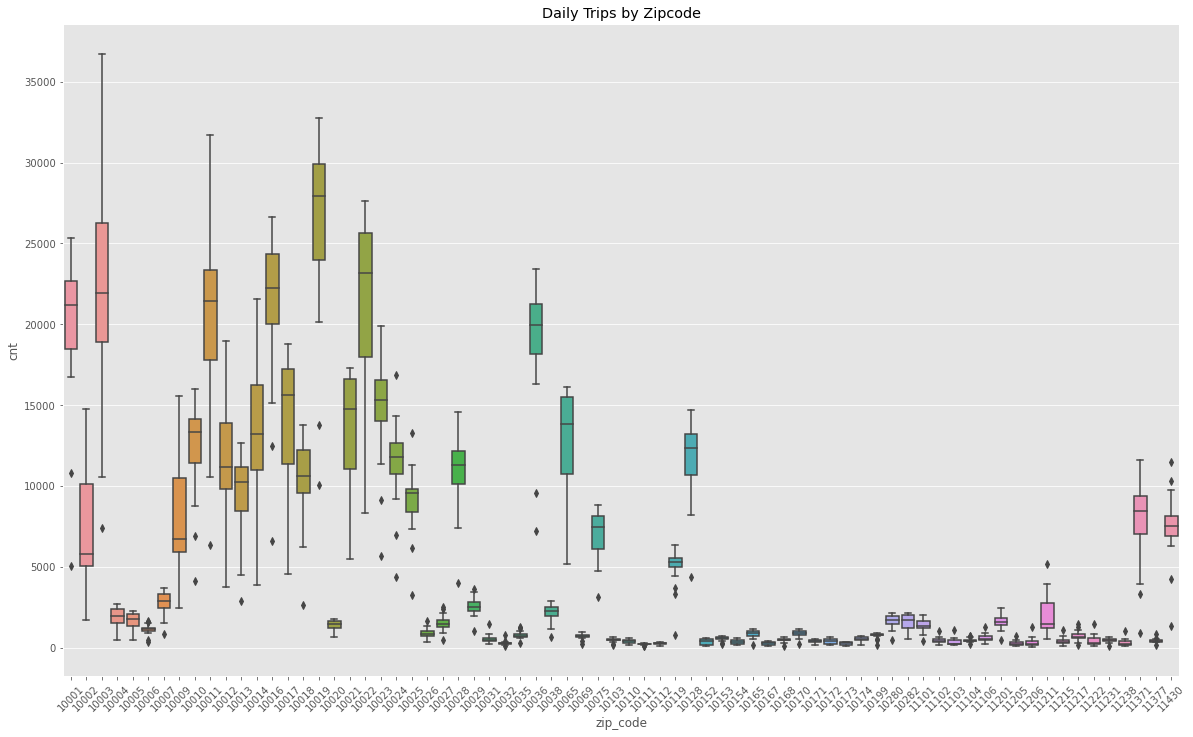

In [77]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='zip_code', y='cnt', data = filtered_df_daily)
plt.xticks(rotation=45)
plt.title('Daily Trips by Zipcode');

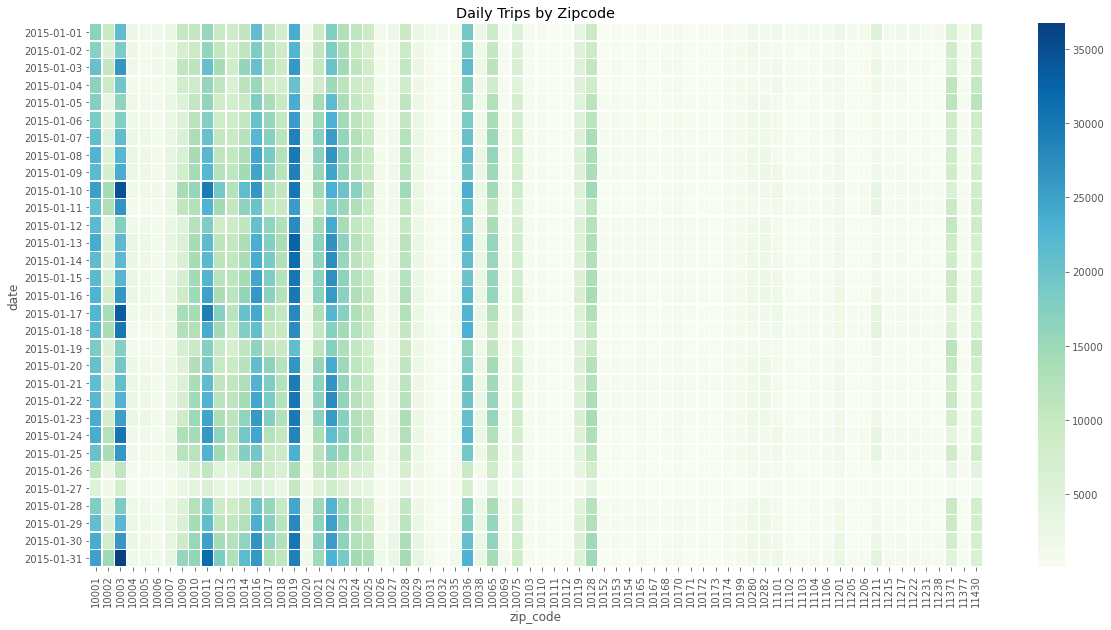

In [98]:
plt.figure(figsize=(20,10))
sns.heatmap(filtered_df_daily.pivot_table('cnt',index='date',columns='zip_code'), lw=.5,  cmap='GnBu');
plt.title('Daily Trips by Zipcode');

In [81]:
filtered_df['hour'] = filtered_df['pickup_hour'].dt.hour
filtered_df.head()

,index,zip_code,city,zip_code_geom,pickup_hour,cnt,date,hour
0,0,10031,New York city,"POLYGON((-73.959767 40.820411, -73.960007 40.8...",2015-01-01,98,2015-01-01,0
1,4,10023,New York city,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",2015-01-01,971,2015-01-01,0
2,6,11205,New York city,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",2015-01-01,52,2015-01-01,0
3,7,10069,New York city,"POLYGON((-73.995969 40.774012, -73.996142 40.7...",2015-01-01,37,2015-01-01,0
4,8,10001,New York city,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01,1221,2015-01-01,0


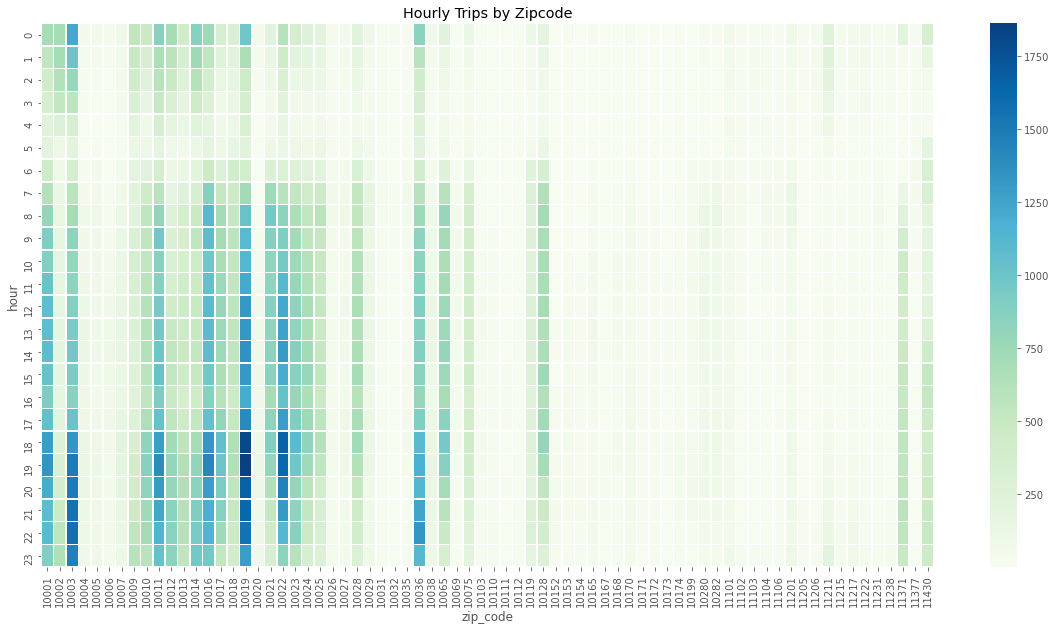

In [105]:
plt.figure(figsize=(20,10))
sns.heatmap(filtered_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'), lw=.5, cmap='GnBu')
plt.title('Hourly Trips by Zipcode');